<a href="https://colab.research.google.com/github/Mario-RJunior/diagnostico-medico-raio-x/blob/main/departamento_medico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento médico

## Importação das bibliotecas e base de dados

In [1]:
# Importado as bibliotecas
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Acessando os arquivos pelo Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Criando o caminho até as imagens
xray_directory = '/content/drive/My Drive/Departamento médico/Dataset/'

In [4]:
# Verificando a presença das imagens no caminho acima
os.listdir(xray_directory)

['.DS_Store', '0', '2', '1', '3']

In [5]:
# Acessando as imagens
image_generator = ImageDataGenerator(rescale=1./225)

In [6]:
# Buscando as imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory=xray_directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 532 images belonging to 4 classes.


In [7]:
# Variáveis para teste
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
# Mostrando cada uma das classes
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

Note que temos 4 classes e portanto nossa rede neural terá 4 neurônios na camada de saída.

In [10]:
# Identificando os labels (funciona como variável dummy)
label_names = {0: 'Covid-19', 1: 'Normais', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

## Visualização dos dados

Queremos inicialmente listar as imagens carrgando-as diretamente do Google Colab.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

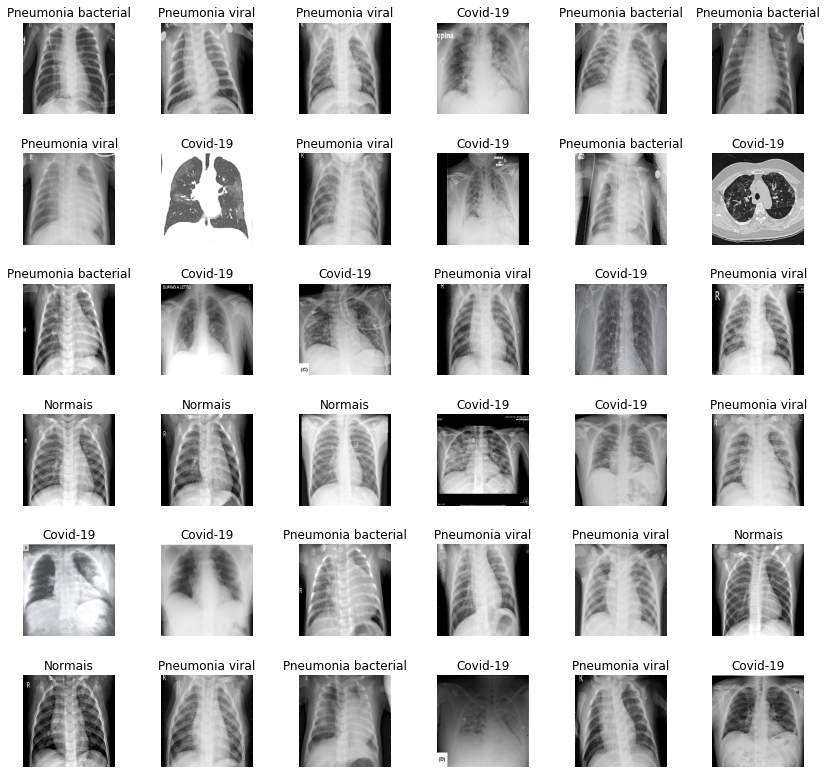

In [26]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(14,14))
axes = axes.ravel()  # Transforma uma matriz em um vetor

for i in np.arange(0,36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)